In [ ]:
import requests
import tarfile
import os
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
from skimage.util import montage
import cv2


In [ ]:
# Diretórios
image_path = "https://github.com/schmoellerIuri/FruitClassifier/raw/master/Images/"

fruits_and_urls = [
    ("Apple", image_path + "Apple.tar.gz"),
    ("Banana", image_path + "Banana.tar.gz"),
    ("Banana", image_path + "Banana_2.tar.gz"),
    ("Clementine", image_path + "Clementine.tar.gz"),
    ("Lemon", image_path + "Lemon.tar.gz"),
    ("Papaya", image_path + "Papaya.tar.gz"),
    ("Pear", image_path + "Pear.tar.gz"),
    ("Pineapple", image_path + "Pineapple.tar.gz"),
    ("Strawberry", image_path + "Strawberry.tar.gz"),
    ("Tomato", image_path + "Tomato.tar.gz"),
    ("Coconut", image_path + "Coconut.tar.gz"),
]

1 - Obtenção do dataset hospedado no github

In [ ]:
# Configurações iniciais
Image_height = 1000
Image_width = 1000
Image_channels = 4
Number_of_images = 80
Current_number_of_images = 0
class_images = {}

# Função para extrair e baixar os dados do GitHub
def download_and_extract(github_url, folder_name):

    os.makedirs(folder_name, exist_ok=True)

    response = requests.get(github_url)
    tar_data = BytesIO(response.content)

    with tarfile.open(fileobj=tar_data, mode="r:gz") as tar:
        tar.extractall(path=folder_name)

# Organizando as imagens para um dicionário para facilitar a manipulação durante o código
def process_fruit_images(folder_name, class_images):

    extracted_files = []
    for root, dirs, files in os.walk(folder_name):
        for file_name in files:
            extracted_files.append(os.path.join(root, file_name))

    extracted_files.sort()

    class_images[folder_name] = []

    for file_path in extracted_files:
        image = Image.open(file_path)
        image_array = np.array(image)

        if len(image_array.shape) == 3 and image_array.shape[2] == 3:
            image_array = np.concatenate([image_array, np.ones_like(image_array[:, :, :1]) * 255], axis=-1)
            class_images[folder_name].append(image_array)
        else:
            class_images[folder_name].append(image_array)

        if(image_array.shape[0] != 1000):
            print(file_path)
            print((image_array.shape))

# Chama as funções para cada imagem do diretório
for fruit, url in fruits_and_urls:
    download_and_extract(url, fruit)
    process_fruit_images(fruit, class_images)


2 - Montage para exibir todas as imagens do projeto

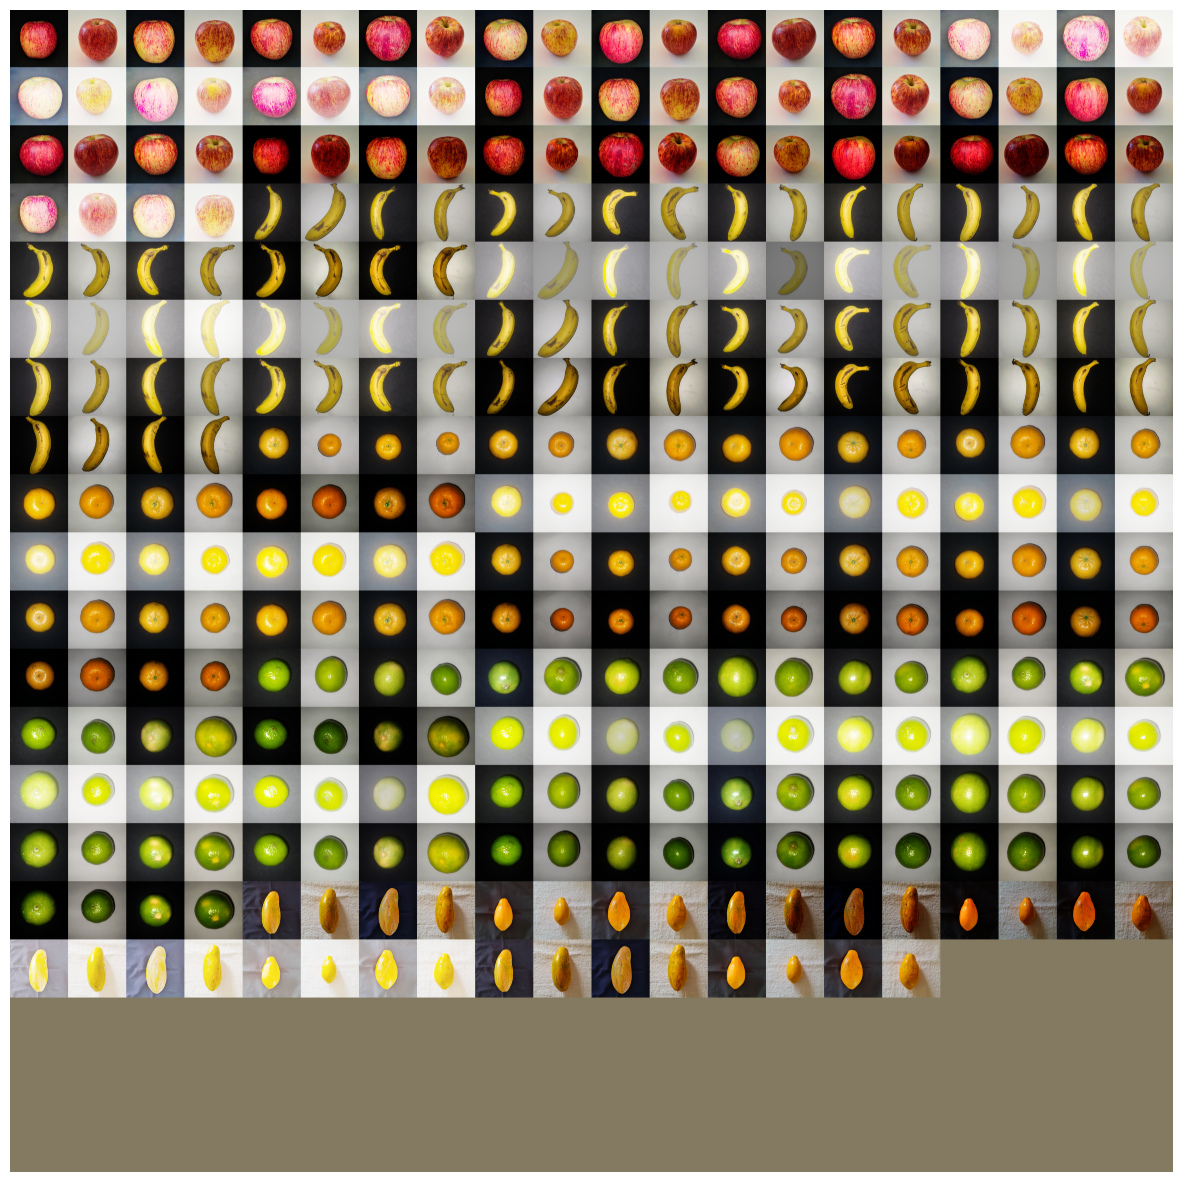

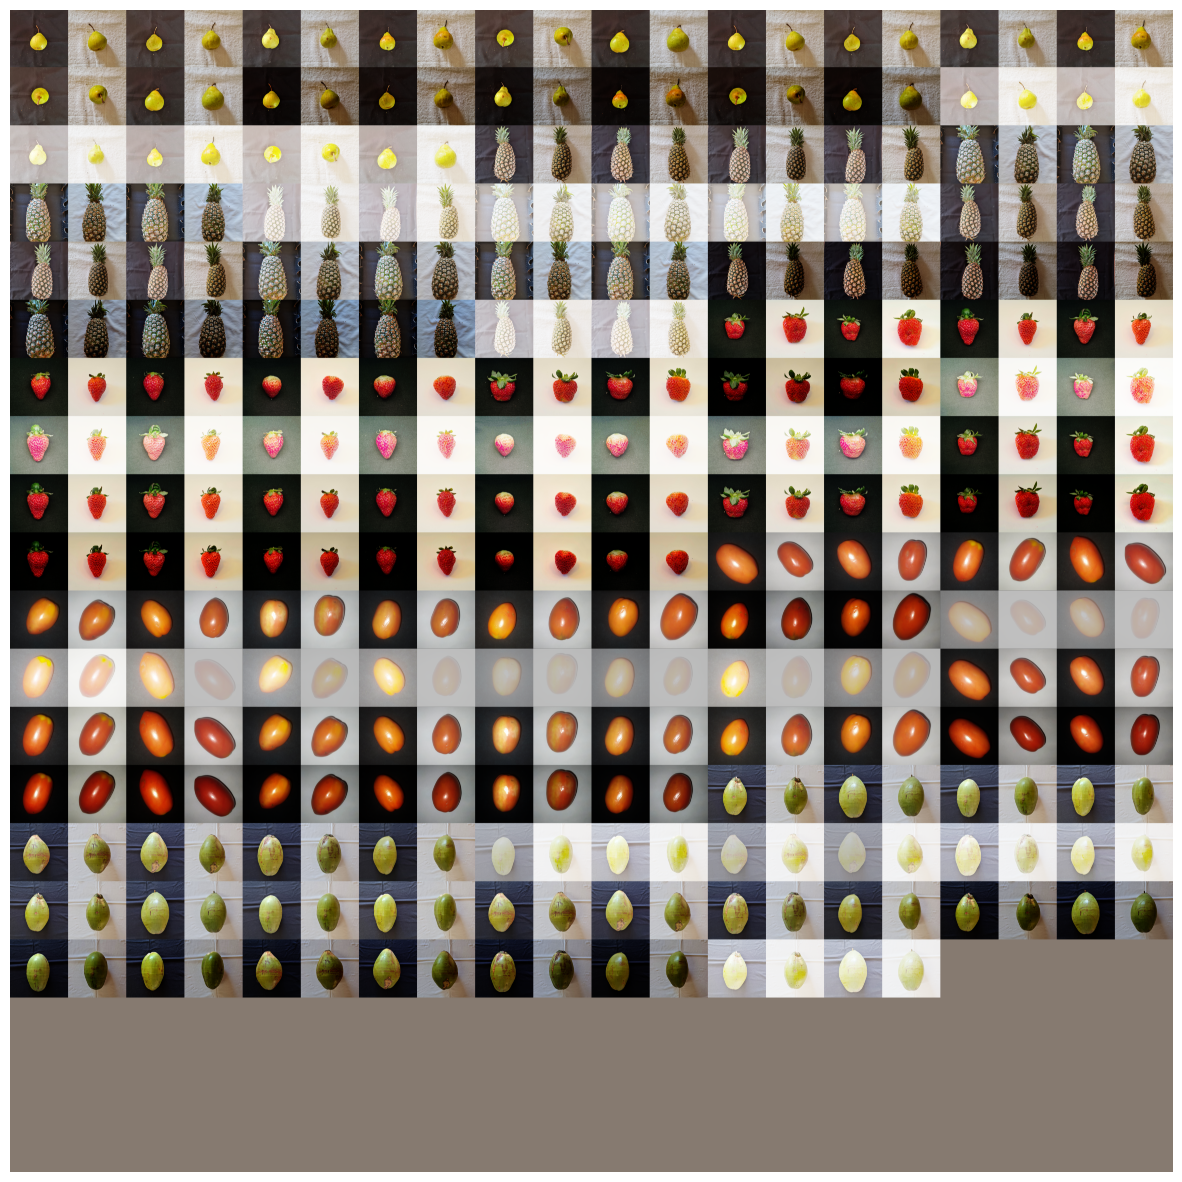

In [ ]:
# Função para exibição das imagens do data base
def create_montage(classimages, Height_size, Length_size, Lines, Columns):
    images_list = []
    for class_fruit, images in classimages.items():
        images_list.extend(images)

    Montage = montage(images_list, grid_shape=(Lines, Columns), channel_axis=-1)

    # Exiba a montagem
    plt.figure(figsize=(Height_size, Length_size))
    plt.imshow(Montage)
    plt.axis('off')
    plt.show()

# Foi dividido em dois montages por motivos de estouro de RAM no colab
half = len(class_images) // 2
items = list(class_images.items())

list1 = dict(items[:half])
list2 = dict(items[half:])

create_montage(list1, 15, 30, 4*len(list1), 20)
create_montage(list2, 15, 30, 4*len(list2), 20)

4 - Data normalization

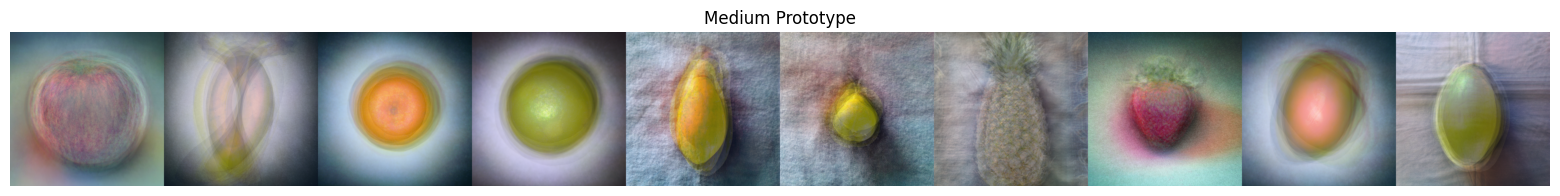

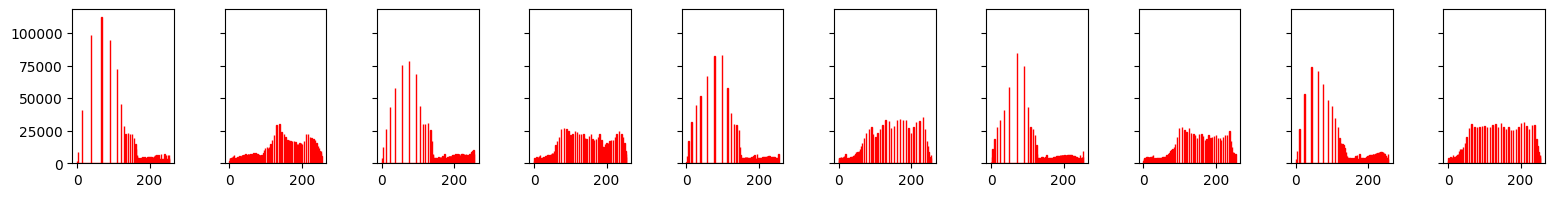

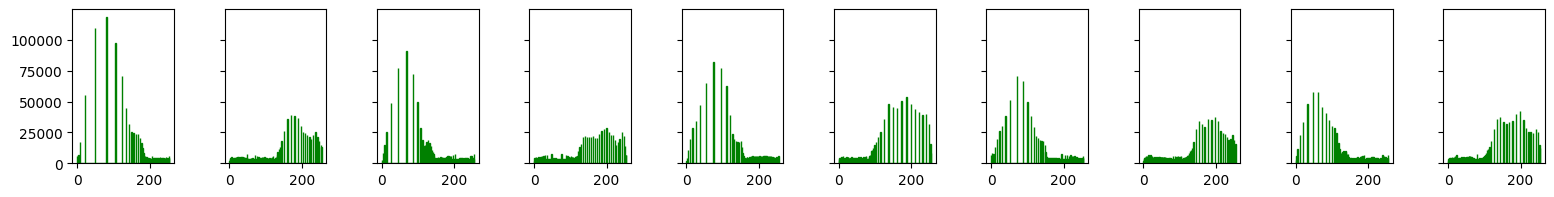

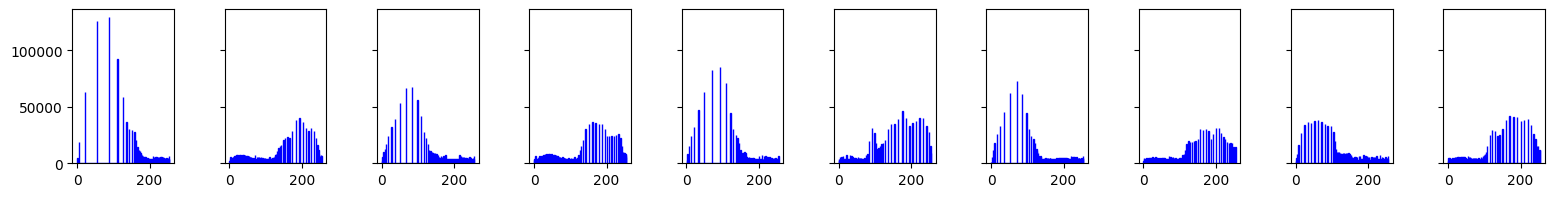

In [ ]:
# Função para equalizar o histograma de cada imagem RGB
def equalize_histograms():
    equalized_images = {}
    for class_fruit, images in class_images.items():
        equalized_class_images = []
        for img in images:
            img_eq = cv2.equalizeHist(img[:, :, 0]), cv2.equalizeHist(img[:, :, 1]), cv2.equalizeHist(img[:, :, 2])
            equalized_class_images.append(np.stack(img_eq, axis=-1).astype('uint8'))

        equalized_images[class_fruit] = equalized_class_images

    return equalized_images

# Pega todas as imagens de uma mesma classe, e retorna a imagem média
def get_medium_prototypes(equalized_images):
    mean_images = {}
    for class_fruit, images in equalized_images.items():
        mean_image = np.mean(images, axis=0)
        mean_images[class_fruit] = mean_image.astype('uint8')

    return np.array(list(mean_images.values()))

# Função para gerar os histogramas de cada camada do RGB
def get_image_histograms(equalized_images):
    red_channel_histograms = []
    blue_channel_histograms = []
    green_channel_histograms = []

    for class_images in equalized_images.values():
        for img in class_images:
            counts, bins = np.histogram(img[:, :, 0], 255)
            red_channel_histograms.append((counts, bins))

            counts, bins = np.histogram(img[:, :, 1], 255)
            green_channel_histograms.append((counts, bins))

            counts, bins = np.histogram(img[:, :, 2], 255)
            blue_channel_histograms.append((counts, bins))

    return red_channel_histograms, blue_channel_histograms, green_channel_histograms

# Função para mostrar os histogramas
def show_histograms(histograms, edge_color):
    num_histograms = len(histograms)
    num_columns = min(num_histograms, 10)

    fig, axes = plt.subplots(1, num_columns, figsize=(19, 2), sharey=True, gridspec_kw={'wspace': 0.5})
    if num_histograms == 1:
        axes = [axes]

    for ax, histogram in zip(axes, histograms):
        counts, bins = histogram
        ax.bar(bins[:-1], counts, width=np.diff(bins), edgecolor=edge_color)

    plt.show()

equalized_images = equalize_histograms()
medium_images = get_medium_prototypes(equalized_images)

Montage = montage(medium_images, grid_shape=(1, 10), channel_axis=-1)

plt.figure(figsize=(25, 2))
plt.title('Medium Prototype')
plt.imshow(Montage)
plt.axis('off')
plt.show()

r_medium_histograms, b_medium_histograms, g_medium_histograms = get_image_histograms(equalized_images)

show_histograms(r_medium_histograms, 'red')
show_histograms(g_medium_histograms, 'green')
show_histograms(b_medium_histograms, 'blue')


6 - Treinamento e Classificação

6.1 - Treinamento

Obtendo o dataset na forma correta

In [ ]:
# Função para salvar as imagens com seus respectivos IDs
def get_images_and_targets():
  images_and_targets = []
  i = 0
  for fruit_class, imgs in class_images.items():
    for img in imgs:
      images_and_targets.append((img[:,:,:-1], get_class_id(fruit_class)))
      i += 1

  images, targets = zip(*images_and_targets)
  images = np.array(images)
  targets = np.array(targets)
  return images, targets

# Definindo o ID da respectiva classe
def get_class_id(classname):
  match classname:
    case 'Banana':
      return 0
    case 'Clementine':
      return 1
    case 'Lemon':
      return 2
    case 'Tomato':
      return 3
    case 'Strawberry':
      return 4
    case 'Apple':
      return 5
    case 'Pineapple':
      return 6
    case 'Pear':
      return 7
    case 'Papaya':
      return 8
    case 'Coconut':
      return 9

images, targets = get_images_and_targets()

resized_images = []

# Foi diminuido a escala das imagens para melhorar o desempenho do treinamento
for img in images:
  resized_images.append(cv2.resize(img, (300, 300)))

resized_images = np.array(resized_images)

Particionamento de dados para treinamento e teste

In [ ]:
from sklearn.model_selection import train_test_split

# Divisão dos dados de treinamento e de teste
X_train, X_test, y_train, y_test = train_test_split(resized_images, targets, test_size = 0.3, shuffle=True)

half = len(X_test)//2
X_test, X_validation = X_test[0:half], X_test[half:]
y_test, y_validation = y_test[0:half], y_test[half:]

print(f'Train data -> type:{type(X_train)} shape:{X_train.shape} size:{X_train.size}\n')
print(f'Test data  -> type:{type(X_test)} shape:{X_test.shape} size:{X_test.size}\n')
print(f'Validation data  -> type:{type(X_validation)} shape:{X_validation.shape} size:{X_validation.size}\n')


Train data -> type:<class 'numpy.ndarray'> shape:(470, 300, 300, 3) size:126900000

Test data  -> type:<class 'numpy.ndarray'> shape:(101, 300, 300, 3) size:27270000

Validation data  -> type:<class 'numpy.ndarray'> shape:(101, 300, 300, 3) size:27270000



O algoritmo escolhido foi o CNN, porém o modelo pré treinado ResNet50 foi utilizado como parte da rede utilizada.

"*We present a residual learning framework to ease the training of networks that are substantially deeper than those used previously. We explicitly reformulate the layers as learning residual functions with reference to the layer inputs, instead of learning unreferenced functions. We provide comprehensive empirical evidence showing that these residual networks are easier to optimize, and can gain accuracy from considerably increased depth. On the ImageNet dataset we evaluate residual nets with a depth of up to 152 layers---8x deeper than VGG nets but still having lower complexity.*" [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

with strategy.scope():
  base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(300, 300, 3))

  for layer in base_model.layers:
      layer.trainable = False

  model = Sequential()
  model.add(base_model)
  model.add(GlobalAveragePooling2D())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(10, activation='softmax'))

  model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

y_train_categorical = to_categorical(y_train, num_classes=10) # ex: class nb 1 = [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], class nb 2 = [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
y_test_categorical = to_categorical(y_test, num_classes=10)
y_validation_categorical =  to_categorical(y_validation, num_classes=10)

history = model.fit(
    X_train,
    y_train_categorical,
    epochs=5,
    batch_size=32,
    validation_data=(X_test, y_test_categorical)
)

94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/5
15/15 [==============================] - 42s 2s/step - loss: 1.8000 - accuracy: 0.4617 - val_loss: 1.1222 - val_accuracy: 0.8416
Epoch 2/5
15/15 [==============================] - 1s 87ms/step - loss: 0.7971 - accuracy: 0.8745 - val_loss: 0.5283 - val_accuracy: 0.9505
Epoch 3/5
15/15 [==============================] - 1s 86ms/step - loss: 0.4118 - accuracy: 0.9511 - val_loss: 0.3216 - val_accuracy: 0.9802
Epoch 4/5
15/15 [==============================] - 1s 86ms/step - loss: 0.2438 - accuracy: 0.9787 - val_loss: 0.2249 - val_accuracy: 0.9901
Epoch 5/5
15/15 [==============================] - 1s 88ms/step - loss: 0.1698 - accuracy: 0.9872 - val_loss: 0.1640 - val_accuracy: 0.9901


In [ ]:
model.evaluate(X_validation, y_validation_categorical)

4/4 [==============================] - 1s 36ms/step - loss: 0.1553 - accuracy: 1.0000


[0.1553269624710083, 1.0]

1/1 [==============================] - 11s 11s/step


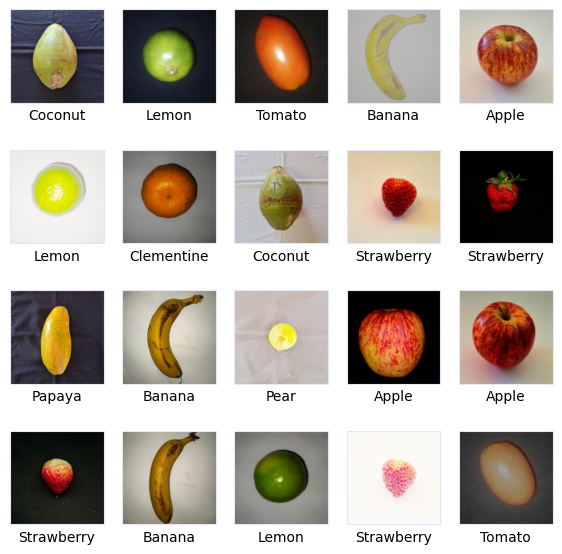

In [ ]:
classes = ['Banana', 'Clementine', 'Lemon', 'Tomato', 'Strawberry', 'Apple', 'Pineapple', 'Pear', 'Papaya', 'Coconut']

X_result = X_validation[:20]

predictions = model.predict(X_result)

y_pred = np.argmax(predictions, axis=1)

classes_predicted = [classes[i] for i in y_pred]

plt.rc('axes',edgecolor='lavender')

fig = plt.figure(figsize=(7, 7))

for i in range(20):
    plt.subplot(4, 5, i + 1)

    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(X_result[i], cmap=plt.cm.binary)
    plt.xlabel(classes_predicted[i], color='black')

plt.show()

In [ ]:
from sklearn import metrics
predictions = model.predict(X_validation)

y_pred = np.argmax(predictions, axis = 1)

print( f"Classification report for classifier CNN:\n" f"{metrics.classification_report(y_validation, y_pred)}\n")

4/4 [==============================] - 1s 32ms/step
Classification report for classifier CNN:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      0.89      0.94         9
           2       0.94      1.00      0.97        16
           3       1.00      1.00      1.00        18
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00        10
           6       1.00      1.00      1.00         9
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00         8
           9       1.00      1.00      1.00         9

    accuracy                           0.99       101
   macro avg       0.99      0.99      0.99       101
weighted avg       0.99      0.99      0.99       101




4/4 [==============================] - 1s 31ms/step
Accuracy:0.99



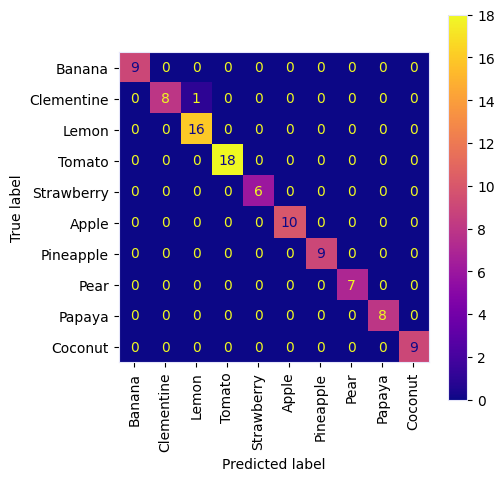

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

y_pred = np.argmax(predictions, axis=1)

accuracy = accuracy_score(y_pred, y_validation)
print(f'Accuracy:{accuracy:.2f}\n')

cm = confusion_matrix(y_validation, y_pred)

fig, ax = plt.subplots(figsize=(5, 5))

ConfusionMatrixDisplay.from_predictions(
    y_validation, y_pred, display_labels=classes, xticks_rotation="vertical",
    ax=ax, colorbar=True, cmap="plasma")

plt.show()